In [6]:
from scipy import *
import numpy as np
import astropy.io.fits as pyfits
from pylab import *
import WLanalysis

In [4]:
hdulist = pyfits.open('mock_v3.2_nres13_r000_rotmat0_shear_catalog.fits')
RA, DEC = hdulist[1].data['ra_mock'], hdulist[1].data['dec_mock']
kappa = hdulist[1].data['kappa']

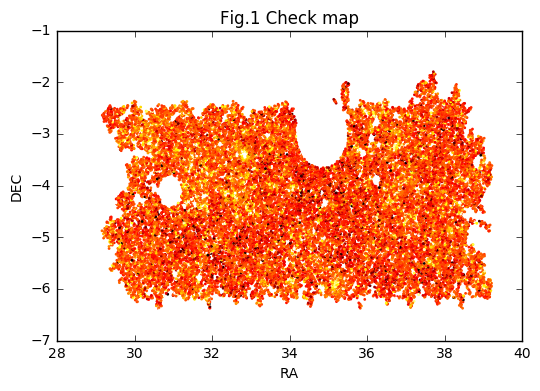

In [47]:
sigma_kappa=std(kappa)
scatter(RA[::100], DEC[::100],s=1,c=kappa[::100],
        vmin=-3*sigma_kappa, vmax=3*sigma_kappa, cmap='hot',edgecolor='face')
xlabel('RA')
ylabel('DEC')
title('Fig.1 Check map')
show()

In [48]:
###########################################
######### read data from files ############
###########################################

nbins, xmin, xmax, dx = 10, -1.000000e+00, 4.000000e+00, 5.000000e-01
bin_centers = arange(xmin+dx/2, xmax, dx)
peaks = zeros((100,10)) ### counts, sigma_counts
sigma_peaks = zeros((100,10))
params = zeros((100, 2))
for i in xrange(1,101):
    fn='test_peaks/model%i_XMM_peak_count_Emode_20rea.dat'%(i)
    f=open(fn)
    l=f.readlines()[0].split(' ')
    om, si8 = float(l[-2]), float(l[-1])
    params[i-1]=om,si8
    peaks[i-1]=loadtxt(fn)[:,1]
    sigma_peaks[i-1] = loadtxt(fn)[:,2]    

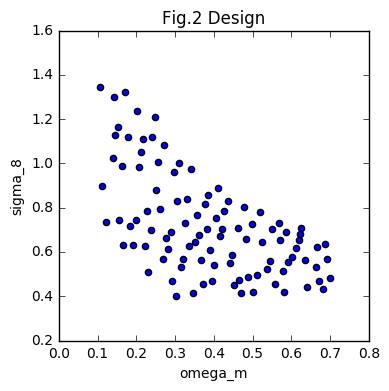

In [49]:
figure(figsize=(4,4))
scatter(params.T[0],params.T[1])
xlabel('omega_m')
ylabel('sigma_8')
title('Fig.2 Design')
show()

In [50]:
########################################
####### interpolation ##################
########################################
#### see normal interpolators: https://docs.scipy.org/doc/scipy/reference/interpolate.html
#### see gaussian process: http://scikit-learn.org/stable/modules/gaussian_process.html
from scipy import interpolate

def buildInterpolator2D(obs_arr, cosmo_params, method='Rbf'):
    '''input:
    obs_arr = (nmodels, nbins)
    cosmo_params = (nmodels, nparams), currently hard-coded to have (omega_m, sigma_8)
    method = 'Rbf', 'linear', or 'clough'
    
    output:
    spline_interps
    
    usage:
    spline_interp = buildInterpolator2D(obs_arr, cosmo_params)
    spline_interp(omega_m, sigma_8)
    '''
    om_arr, si8_arr = cosmo_params.T
    spline_interps = list()
    nbins = obs_arr.shape[-1]
    for ibin in xrange(nbins):
        model = obs_arr[:,ibin]
        if method == 'Rbf':
            iinterp = interpolate.Rbf(om_arr, si8_arr, model)#
        elif method == 'linear':
            iinterp = interpolate.LinearNDInterpolator(cosmo_params,model)#
        elif method == 'clough':
            iinterp = interpolate.CloughTocher2DInterpolator(cosmo_params,model)#
        spline_interps.append(iinterp)
    def interp_cosmo (params):
        '''Interpolate the peak counts for certain param set.'''
        omega_m, sigma_8 = params
        gen_peaks = lambda ibin: spline_interps[ibin](omega_m, sigma_8)
        peaks_interp = array(map(gen_peaks, xrange(nbins)))
        peaks_interp = peaks_interp.reshape(-1,1).squeeze()
        return peaks_interp
    return interp_cosmo

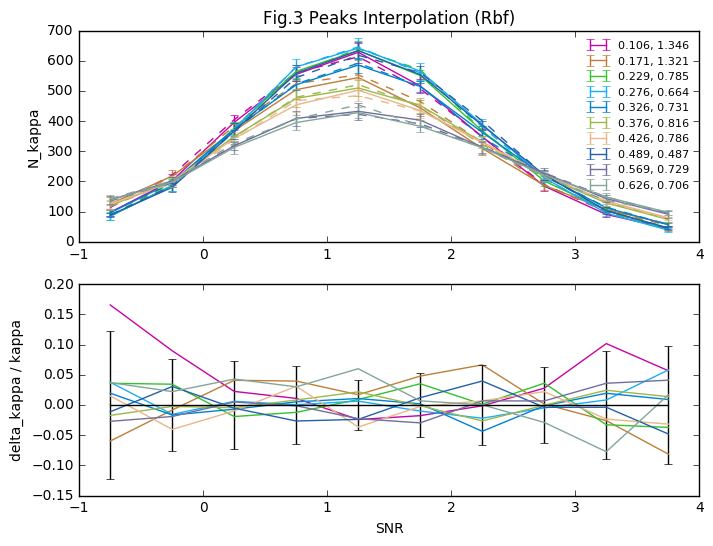

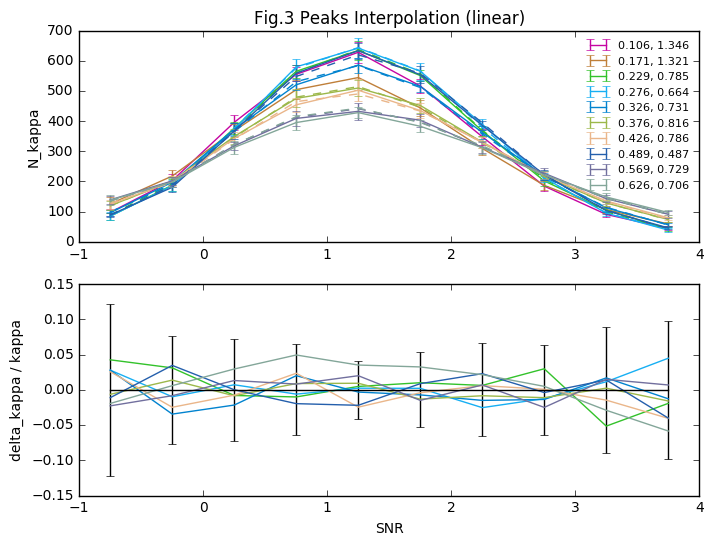

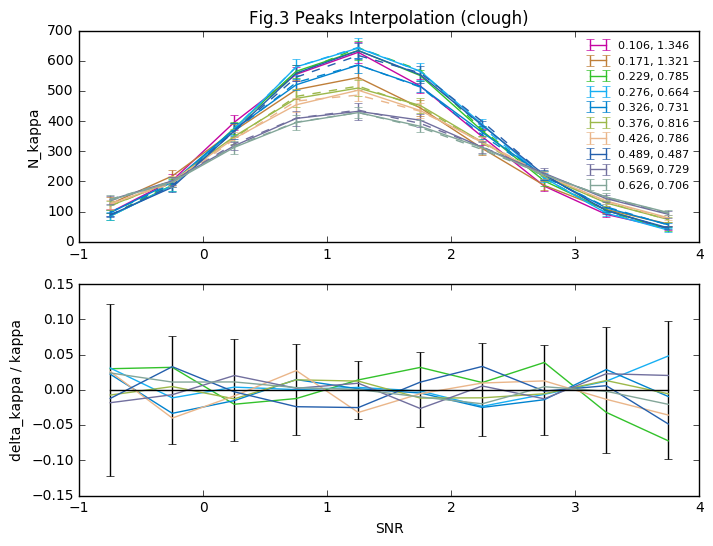

In [58]:
for imethod in ('Rbf', 'linear', 'clough'):
    f=figure(figsize=(8,6))
    ax1=f.add_subplot(211)
    ax2=f.add_subplot(212)
    seed(10)
    for i in arange(0,100,10):
        icolor=rand(3)
        idx=delete(arange(100),i)
        spline_interp = buildInterpolator2D(peaks[idx], params[idx], method=imethod)
        peaks_interpolated = spline_interp(params[i])
        peaks_real = peaks[i]
        sigma_peaks_real = sigma_peaks[i]

        ax1.errorbar(bin_centers, peaks_real, sigma_peaks_real, color=icolor, 
                     label='%.3f, %.3f'%(params[i][0],params[i][1]))
        ax1.plot(bin_centers, peaks_interpolated, '--', color=icolor)#, label='N_interpolated')
        #ax1.set_title('omega_m=%.3f sigma_8=%.3f'%(params[i][0],params[i][1]))
        ax2.plot(bin_centers, peaks_interpolated/peaks_real-1, '-',color=icolor)

    ax2.errorbar(bin_centers, zeros(nbins), sigma_peaks_real/peaks_real, color='k')
    ax1.set_ylabel('N_kappa')
    ax1.legend(fontsize=8, loc=0,frameon=0)
    ax2.set_xlabel('SNR')
    ax2.set_ylabel('delta_kappa / kappa')
    ax1.set_title('Fig.3 Peaks Interpolation (%s)'%(imethod))
    show()